In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='2'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=4,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split4/",
    project_name="breakfast-split-4",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 8, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 4, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split4/', 'project_name': 'breakfast-split-4', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split4.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split4.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_split':

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1136
Number of videos not found in train fold is 0
Number of videos logged in test fold is 576
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [10]:
loaded_vidid_selected_frames = np.load("/home/dipika16/ar/TimestampActionSeg/data/breakfast_annotation_all.npy", allow_pickle=True).item()
# loaded_vidid_selected_frames
video_id_boundary_frames = pickle.load(open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames

In [11]:
loaded_mean_var_actions = pickle.load(open("dump_dir/mean_var_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class):
    mean_class, std_class = loaded_mean_var_actions[cur_class]
    mean_class = mean_class * 10
    prob = cur_len * torch.log(torch.tensor(mean_class, device=device) + 1e-5)
    prob = prob - mean_class
    factorials = torch.cumsum(torch.log(torch.arange(1, torch.max(cur_len)+1, 1).type(torch.float).to(device)), 
                              dim=0)[min(cur_len)-1:]
    prob = prob - factorials
    return prob

# get_possion_prob(torch.arange(10, 21), 20)

In [12]:
prob_video_each_segment_dict = {}

In [13]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):

        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[cur_ele]
        label_next_ele = labels[next_ele]

        indices = torch.arange(cur_ele, next_ele).to(cumsum_feat.device)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]

        cur_boundary_len = indices - cur_boundary
        len_prob = get_possion_prob(cur_boundary_len, label_cur_ele.item())

        prob = torch.softmax((left_sum + right_sum + len_prob), dim=0)
#         prob = torch.softmax((left_sum + right_sum), dim=0)

        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)
    
    return prob_each_segment

In [14]:
def calculate_element_probb(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_video = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [15]:
def get_estimated_loss(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames[0]
        if start_ele_idx > 0:
            start_ele_label_idx = labels[selected_frames[0]]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob.unsqueeze(0))
        
        for i, cur_ele in enumerate(selected_frames[:-1]):
            next_ele = selected_frames[i + 1]
            label_cur_ele = labels[cur_ele]
            label_next_ele = labels[next_ele]

            indices = torch.arange(cur_ele, next_ele)
            strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
            end_index = cumsum_feat[next_ele - 1, :][None, :]
            left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
            right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
            current_vid_prob_arr.append((left_sum + right_sum)  * (prob_each_video[i]))
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = labels[selected_frames[-1]]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames[-1] - 1, :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob.unsqueeze(0))
            
        loss_arr.append(torch.cat(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [27]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_estimated_boundaries():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames, video_id_boundary_frames
    estimated_boundary_dict = {}
    for ele in video_id_boundary_frames.keys():
        if (ele + ".txt") not in train_split_file_list:
            continue
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        selected_ele_list = loaded_vidid_selected_frames[ele + ".txt"]
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_ele_list[i], selected_ele_list[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_ele_list[i]) or (estimated_boundary > selected_ele_list[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [28]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_boundary_err():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for ele in video_id_boundary_frames.keys():
        if ele + ".txt" not in train_split_file_list:
            continue
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(video_id_boundary_frames[ele][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = video_id_boundary_frames[ele][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [29]:
get_boundary_err()

Train Boundary avergage error = 84.449
Train From boundary avergage accuracy = 89.000


In [18]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [19]:
def get_single_random(labels_all, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((labels_all.shape[0], labels_all.shape[1]), dtype=torch.long, device=labels_all.device) * (-100)
    for iter_num, labels in enumerate(labels_all):
        cur_vidid = video_ids[iter_num]
        frame_idx_tensor = torch.from_numpy(np.array(loaded_vidid_selected_frames[cur_vidid + ".txt"]))
        boundary_target_tensor[iter_num, frame_idx_tensor] = labels[frame_idx_tensor]

    return boundary_target_tensor

In [20]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split4/'

In [30]:
initialize_epoch = 15
expectation_cal_gap = 5
best_val_acc = 0
for epoch in range(15, 1000):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        boundary_target_tensor = get_single_random(item_2, item[4])
        
        loss = 0
        for p in predictions:
            if epoch <= initialize_epoch:
                loss += ce_criterion(p, boundary_target_tensor)
                loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                    F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                                            max=16) * src_mask_mse[:, :, 1:])
            else:
                prob = torch.softmax(p, dim=1)
                prob = prob.permute(0, 2, 1)
                es_loss, _ = get_estimated_loss(prob, item_1, item[4], item_2)
                loss += es_loss
            

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")
    if epoch == initialize_epoch:
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-initial-15-epochs.wt")
    # Calculating Expectation Step
    model.eval()
    if (epoch >= initialize_epoch) and (epoch % expectation_cal_gap == 0):
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0

        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                middle_pred, predictions = model(item_0, src_mask_mse)
                prob = torch.softmax(predictions[-1], dim=1)
                prob = prob.permute(0, 2, 1)
                calculate_element_probb(prob, item_1, item[4], item_2)
                
                if i % 10 == 0:
#                     pred = torch.argmax(prob, dim=2)
#                     correct += float(torch.sum((pred == item_2) * src_mask).item())
#                     total += float(torch.sum(src_mask).item())
                    print(f"Epoch {epoch} iter {i}")
                    
#         print(f"Epoch {epoch} After Expectation}, train acc. {correct * 100.0 / total: .3f}")
        get_boundary_err()

    print("Calculating Validation Data Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

            middle_pred, predictions = model(item_0, src_mask_mse)

            pred = torch.argmax(predictions[-1], dim=1)
            correct += float(torch.sum((pred == item_2) * src_mask).item())
            total += float(torch.sum(src_mask).item())
    val_acc = correct * 100.0 / total
    if val_acc > best_val_acc:
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-best-model.wt")
    torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-last-model.wt")
    print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Starting Training
Training:: Epoch 15, Iteration 0, Current loss 1.8556843996047974 Accuracy 71.94321352371574
Training:: Epoch 15, Iteration 10, Current loss 1.4181013107299805 Accuracy 80.85716561778061
Training:: Epoch 15, Iteration 20, Current loss 1.330886960029602 Accuracy 62.76542467948718
Training:: Epoch 15, Iteration 30, Current loss 1.2861876487731934 Accuracy 69.17018605182056
Training:: Epoch 15, Iteration 40, Current loss 2.0291144847869873 Accuracy 71.45560637123482
Training:: Epoch 15, Iteration 50, Current loss 1.2951205968856812 Accuracy 80.90161182001343
Training:: Epoch 15, Iteration 60, Current loss 0.8947985172271729 Accuracy 68.93127186547794
Training:: Epoch 15, Iteration 70, Current loss 1.6893976926803589 Accuracy 65.86749162155195
Training:: Epoch 15, Iteration 80, Current loss 2.151519775390625 Accuracy 81.5013582455443
Training:: Epoch 15, Iteration 90, Current loss 1.4900544881820679 Accuracy 77.8420666612338
Training:: Epoch 15, Iteration 100, Current los

Training:: Epoch 20, Iteration 30, Current loss 1.708415991407148 Accuracy 87.51558603491272
Training:: Epoch 20, Iteration 40, Current loss 1.8237482708133728 Accuracy 81.64462191165461
Training:: Epoch 20, Iteration 50, Current loss 2.772337122916954 Accuracy 78.36148041681639
Training:: Epoch 20, Iteration 60, Current loss 3.670781148245705 Accuracy 69.35190449118818
Training:: Epoch 20, Iteration 70, Current loss 1.7826626465789985 Accuracy 86.00746268656717
Training:: Epoch 20, Iteration 80, Current loss 3.478642447049301 Accuracy 73.5360324656796
Training:: Epoch 20, Iteration 90, Current loss 1.7740410474433908 Accuracy 81.7632241813602
Training:: Epoch 20, Iteration 100, Current loss 1.9707998470944488 Accuracy 81.97882197220383
Training:: Epoch 20, Iteration 110, Current loss 1.6678847773083456 Accuracy 86.96003805899144
Training:: Epoch 20, Iteration 120, Current loss 2.6124297487862607 Accuracy 77.31218470208609
Training:: Epoch 20, Iteration 130, Current loss 2.143706415639

Training:: Epoch 25, Iteration 120, Current loss 1.0509257626096835 Accuracy 88.22977556469654
Training:: Epoch 25, Iteration 130, Current loss 1.385312951866557 Accuracy 85.83347238444853
Training:: Epoch 25, Iteration 140, Current loss 1.1184941635853198 Accuracy 85.53598737112131
Calculating Expectation
Epoch 25 iter 0
Epoch 25 iter 10
Epoch 25 iter 20
Epoch 25 iter 30
Epoch 25 iter 40
Epoch 25 iter 50
Epoch 25 iter 60
Epoch 25 iter 70
Epoch 25 iter 80
Epoch 25 iter 90
Epoch 25 iter 100
Epoch 25 iter 110
Epoch 25 iter 120
Epoch 25 iter 130
Epoch 25 iter 140
Train Boundary avergage error = 86.473
Train From boundary avergage accuracy = 87.778
Calculating Validation Data Accuracy
Validation:: Epoch 25, Probability Accuracy 63.2057235668207
Starting Training
Training:: Epoch 26, Iteration 0, Current loss 1.0592093790267907 Accuracy 84.29200257183837
Training:: Epoch 26, Iteration 10, Current loss 1.2576144873180584 Accuracy 86.45848119233499
Training:: Epoch 26, Iteration 20, Current l

Calculating Expectation
Epoch 30 iter 0
Epoch 30 iter 10
Epoch 30 iter 20
Epoch 30 iter 30
Epoch 30 iter 40
Epoch 30 iter 50
Epoch 30 iter 60
Epoch 30 iter 70
Epoch 30 iter 80
Epoch 30 iter 90
Epoch 30 iter 100
Epoch 30 iter 110
Epoch 30 iter 120
Epoch 30 iter 130
Epoch 30 iter 140
Train Boundary avergage error = 89.456
Train From boundary avergage accuracy = 87.100
Calculating Validation Data Accuracy
Validation:: Epoch 30, Probability Accuracy 62.801064059242215
Starting Training
Training:: Epoch 31, Iteration 0, Current loss 1.3611515759945576 Accuracy 79.0379567938623
Training:: Epoch 31, Iteration 10, Current loss 1.136381931018063 Accuracy 84.18867924528301
Training:: Epoch 31, Iteration 20, Current loss 1.0240495131145668 Accuracy 85.40748898678414
Training:: Epoch 31, Iteration 30, Current loss 1.1373213464637146 Accuracy 88.5356928286635
Training:: Epoch 31, Iteration 40, Current loss 1.0210399906740844 Accuracy 82.20176797594094
Training:: Epoch 31, Iteration 50, Current loss

Epoch 35 iter 100
Epoch 35 iter 110
Epoch 35 iter 120
Epoch 35 iter 130
Epoch 35 iter 140
Train Boundary avergage error = 83.947
Train From boundary avergage accuracy = 87.601
Calculating Validation Data Accuracy
Validation:: Epoch 35, Probability Accuracy 63.73064529833528
Starting Training
Training:: Epoch 36, Iteration 0, Current loss 2.073209094847968 Accuracy 89.20977153595095
Training:: Epoch 36, Iteration 10, Current loss 1.465784879713677 Accuracy 77.49129256965944
Training:: Epoch 36, Iteration 20, Current loss 0.9004424373195352 Accuracy 83.0796721917555
Training:: Epoch 36, Iteration 30, Current loss 1.0556056273119254 Accuracy 87.16550319953461
Training:: Epoch 36, Iteration 40, Current loss 0.7337957745337411 Accuracy 78.68277072365025
Training:: Epoch 36, Iteration 50, Current loss 0.6379597241566372 Accuracy 87.26482458863707
Training:: Epoch 36, Iteration 60, Current loss 0.7494418367072104 Accuracy 82.71788927526633
Training:: Epoch 36, Iteration 70, Current loss 0.769

Validation:: Epoch 40, Probability Accuracy 65.06308864763822
Starting Training
Training:: Epoch 41, Iteration 0, Current loss 0.40734903190962124 Accuracy 88.36284560422492
Training:: Epoch 41, Iteration 10, Current loss 0.9147332756886107 Accuracy 78.30381881701
Training:: Epoch 41, Iteration 20, Current loss 0.5051849820207027 Accuracy 86.9837296620776
Training:: Epoch 41, Iteration 30, Current loss 0.4127926116859051 Accuracy 85.33021210186564
Training:: Epoch 41, Iteration 40, Current loss 0.5042227840838841 Accuracy 85.56298773690078
Training:: Epoch 41, Iteration 50, Current loss 0.3831133439187121 Accuracy 88.79855465221318
Training:: Epoch 41, Iteration 60, Current loss 0.3761551645338624 Accuracy 89.79477402713917
Training:: Epoch 41, Iteration 70, Current loss 0.6021401265997114 Accuracy 87.21435006962078
Training:: Epoch 41, Iteration 80, Current loss 0.4721830521324605 Accuracy 88.07105571966171
Training:: Epoch 41, Iteration 90, Current loss 0.4385665022962484 Accuracy 90

Training:: Epoch 46, Iteration 20, Current loss 0.40172782740416435 Accuracy 88.55116934815061
Training:: Epoch 46, Iteration 30, Current loss 0.4288736589310698 Accuracy 91.9994986631016
Training:: Epoch 46, Iteration 40, Current loss 0.5978105013005827 Accuracy 79.17876399834094
Training:: Epoch 46, Iteration 50, Current loss 0.5435002439833422 Accuracy 80.18021691266411
Training:: Epoch 46, Iteration 60, Current loss 0.44555304675373175 Accuracy 90.18360444516026
Training:: Epoch 46, Iteration 70, Current loss 0.5596945418445295 Accuracy 91.5614478114478
Training:: Epoch 46, Iteration 80, Current loss 0.35242536004940317 Accuracy 91.29268386157207
Training:: Epoch 46, Iteration 90, Current loss 0.34987923668106735 Accuracy 91.92923459317201
Training:: Epoch 46, Iteration 100, Current loss 0.5633921469913205 Accuracy 86.80134283526709
Training:: Epoch 46, Iteration 110, Current loss 0.4381263782117122 Accuracy 83.05408970976254
Training:: Epoch 46, Iteration 120, Current loss 0.37401

Training:: Epoch 51, Iteration 40, Current loss 0.3161944675400019 Accuracy 91.58594491927825
Training:: Epoch 51, Iteration 50, Current loss 0.3691043604240503 Accuracy 89.39381374906709
Training:: Epoch 51, Iteration 60, Current loss 0.26644665051306754 Accuracy 91.02757839063091
Training:: Epoch 51, Iteration 70, Current loss 0.32504380058096655 Accuracy 90.59192929410396
Training:: Epoch 51, Iteration 80, Current loss 0.30461275777049934 Accuracy 91.56034302447186
Training:: Epoch 51, Iteration 90, Current loss 0.3284516188700133 Accuracy 89.00438525255807
Training:: Epoch 51, Iteration 100, Current loss 0.3099760034189155 Accuracy 83.83450272858893
Training:: Epoch 51, Iteration 110, Current loss 0.39376971512539327 Accuracy 88.53895018388499
Training:: Epoch 51, Iteration 120, Current loss 0.4165233919314221 Accuracy 88.82888963887952
Training:: Epoch 51, Iteration 130, Current loss 0.3865130164923014 Accuracy 88.2765623557648
Training:: Epoch 51, Iteration 140, Current loss 0.47

Training:: Epoch 56, Iteration 60, Current loss 0.3764832582731947 Accuracy 81.65303611493088
Training:: Epoch 56, Iteration 70, Current loss 0.2768430068505099 Accuracy 86.59351145038168
Training:: Epoch 56, Iteration 80, Current loss 0.30572230903101183 Accuracy 86.93798902253883
Training:: Epoch 56, Iteration 90, Current loss 0.23534494758982782 Accuracy 87.40649711476811
Training:: Epoch 56, Iteration 100, Current loss 0.26824423853026014 Accuracy 87.48908932208322
Training:: Epoch 56, Iteration 110, Current loss 0.4049795796622098 Accuracy 86.73887321379813
Training:: Epoch 56, Iteration 120, Current loss 0.3438943991234672 Accuracy 88.58737123235406
Training:: Epoch 56, Iteration 130, Current loss 0.2625591576695111 Accuracy 90.60504339282791
Training:: Epoch 56, Iteration 140, Current loss 0.39099057404028353 Accuracy 85.44231319782422
Calculating Validation Data Accuracy
Validation:: Epoch 56, Probability Accuracy 65.61619683788783
Starting Training
Training:: Epoch 57, Iterati

Training:: Epoch 61, Iteration 80, Current loss 0.9850010570021257 Accuracy 84.57423094070441
Training:: Epoch 61, Iteration 90, Current loss 0.8642312277705559 Accuracy 86.88274087180312
Training:: Epoch 61, Iteration 100, Current loss 0.6212537778957227 Accuracy 85.88046695166064
Training:: Epoch 61, Iteration 110, Current loss 0.6852303233429617 Accuracy 82.63452914798206
Training:: Epoch 61, Iteration 120, Current loss 0.9991747887791484 Accuracy 84.58767013610888
Training:: Epoch 61, Iteration 130, Current loss 0.48637782254446216 Accuracy 90.32056293979672
Training:: Epoch 61, Iteration 140, Current loss 0.7762422962274276 Accuracy 87.28005087979648
Calculating Validation Data Accuracy
Validation:: Epoch 61, Probability Accuracy 64.7506683050216
Starting Training
Training:: Epoch 62, Iteration 0, Current loss 0.6353740568318589 Accuracy 83.73379326751517
Training:: Epoch 62, Iteration 10, Current loss 0.4260926235731201 Accuracy 88.04429755899577
Training:: Epoch 62, Iteration 20

Training:: Epoch 66, Iteration 100, Current loss 0.34190299984984246 Accuracy 84.246707356248
Training:: Epoch 66, Iteration 110, Current loss 0.2592112062649825 Accuracy 86.60139251523063
Training:: Epoch 66, Iteration 120, Current loss 0.30667458736572467 Accuracy 89.23939869867624
Training:: Epoch 66, Iteration 130, Current loss 0.4233429737241124 Accuracy 88.32590802688213
Training:: Epoch 66, Iteration 140, Current loss 0.23705175955731822 Accuracy 92.39894150926179
Calculating Validation Data Accuracy
Validation:: Epoch 66, Probability Accuracy 66.2434885195328
Starting Training
Training:: Epoch 67, Iteration 0, Current loss 0.31572636717879665 Accuracy 80.45170485692358
Training:: Epoch 67, Iteration 10, Current loss 0.26745049141048594 Accuracy 91.4131254714609
Training:: Epoch 67, Iteration 20, Current loss 0.309748468404792 Accuracy 89.77749113189294
Training:: Epoch 67, Iteration 30, Current loss 0.4596784032996849 Accuracy 88.03276412605858
Training:: Epoch 67, Iteration 40

Training:: Epoch 71, Iteration 120, Current loss 0.6094458080686026 Accuracy 84.34579439252336
Training:: Epoch 71, Iteration 130, Current loss 0.3272621192563475 Accuracy 90.26543285035919
Training:: Epoch 71, Iteration 140, Current loss 0.49984937759561243 Accuracy 85.24915624379591
Calculating Validation Data Accuracy
Validation:: Epoch 71, Probability Accuracy 65.54201334649247
Starting Training
Training:: Epoch 72, Iteration 0, Current loss 0.3946254667046988 Accuracy 85.32058248206911
Training:: Epoch 72, Iteration 10, Current loss 0.31394290010167 Accuracy 87.02424800491099
Training:: Epoch 72, Iteration 20, Current loss 0.5072028993859055 Accuracy 89.94950709305121
Training:: Epoch 72, Iteration 30, Current loss 1.3319697606876821 Accuracy 81.64786937850974
Training:: Epoch 72, Iteration 40, Current loss 0.4775830055870498 Accuracy 89.7846378474214
Training:: Epoch 72, Iteration 50, Current loss 0.45671758778261184 Accuracy 89.13529411764706
Training:: Epoch 72, Iteration 60, C

Training:: Epoch 76, Iteration 140, Current loss 0.4495535550754782 Accuracy 86.9930367299208
Calculating Validation Data Accuracy
Validation:: Epoch 76, Probability Accuracy 65.83057732403479
Starting Training
Training:: Epoch 77, Iteration 0, Current loss 0.28437464559690373 Accuracy 86.16792249730894
Training:: Epoch 77, Iteration 10, Current loss 0.3716090445559618 Accuracy 90.21676181020932
Training:: Epoch 77, Iteration 20, Current loss 0.26087532554853504 Accuracy 81.81400477853336
Training:: Epoch 77, Iteration 30, Current loss 0.35784000637836566 Accuracy 87.57848551327635
Training:: Epoch 77, Iteration 40, Current loss 0.2970251876711101 Accuracy 89.1995221027479
Training:: Epoch 77, Iteration 50, Current loss 0.5009995817653294 Accuracy 89.26824244296823
Training:: Epoch 77, Iteration 60, Current loss 0.39201833588473567 Accuracy 90.85082613041689
Training:: Epoch 77, Iteration 70, Current loss 1.6563327023749812 Accuracy 81.61071510692113
Training:: Epoch 77, Iteration 80, 

Training:: Epoch 82, Iteration 0, Current loss 0.38005955245846074 Accuracy 89.23573735199139
Training:: Epoch 82, Iteration 10, Current loss 0.3081612081348332 Accuracy 85.31495493758736
Training:: Epoch 82, Iteration 20, Current loss 0.5283290958499683 Accuracy 86.59276103846882
Training:: Epoch 82, Iteration 30, Current loss 0.5456321338608261 Accuracy 80.8082271147161
Training:: Epoch 82, Iteration 40, Current loss 0.46545215092539693 Accuracy 83.40816997043041
Training:: Epoch 82, Iteration 50, Current loss 0.36198872065710797 Accuracy 85.67541363025052
Training:: Epoch 82, Iteration 60, Current loss 0.40645506790904606 Accuracy 89.6981336484956
Training:: Epoch 82, Iteration 70, Current loss 0.36178684813610584 Accuracy 85.084358021161
Training:: Epoch 82, Iteration 80, Current loss 0.2823427341160984 Accuracy 89.7539174575149
Training:: Epoch 82, Iteration 90, Current loss 0.26343382306784413 Accuracy 89.15245342429809
Training:: Epoch 82, Iteration 100, Current loss 0.422271954

Training:: Epoch 87, Iteration 20, Current loss 0.21848162574571972 Accuracy 90.00335457900033
Training:: Epoch 87, Iteration 30, Current loss 0.2685748072098415 Accuracy 89.90805604203152
Training:: Epoch 87, Iteration 40, Current loss 0.28738588328364323 Accuracy 84.98171074845244
Training:: Epoch 87, Iteration 50, Current loss 0.298152991840902 Accuracy 86.18698298735758
Training:: Epoch 87, Iteration 60, Current loss 0.35960799734993537 Accuracy 88.84991057917182
Training:: Epoch 87, Iteration 70, Current loss 0.2596443472115506 Accuracy 86.62177985948477
Training:: Epoch 87, Iteration 80, Current loss 0.17572684007811887 Accuracy 87.19641593963688
Training:: Epoch 87, Iteration 90, Current loss 0.2969113138727379 Accuracy 89.09267581683469
Training:: Epoch 87, Iteration 100, Current loss 0.4398046874821566 Accuracy 76.94142592101775
Training:: Epoch 87, Iteration 110, Current loss 0.3731720962925324 Accuracy 89.15781326954198
Training:: Epoch 87, Iteration 120, Current loss 0.3109

Training:: Epoch 92, Iteration 40, Current loss 0.17510002474317954 Accuracy 88.68701550387597
Training:: Epoch 92, Iteration 50, Current loss 0.1746223783561215 Accuracy 90.90682237859959
Training:: Epoch 92, Iteration 60, Current loss 0.20502691968902495 Accuracy 86.95040710584752
Training:: Epoch 92, Iteration 70, Current loss 0.1585137150512047 Accuracy 89.76613036987892
Training:: Epoch 92, Iteration 80, Current loss 0.18724485809395114 Accuracy 85.20474077402685
Training:: Epoch 92, Iteration 90, Current loss 0.18146949937836931 Accuracy 89.76187081135035
Training:: Epoch 92, Iteration 100, Current loss 0.2690820478469832 Accuracy 83.36008560727662
Training:: Epoch 92, Iteration 110, Current loss 0.16465824222668896 Accuracy 89.79645783769494
Training:: Epoch 92, Iteration 120, Current loss 0.2702561006588964 Accuracy 86.73139158576052
Training:: Epoch 92, Iteration 130, Current loss 0.27179068253638156 Accuracy 84.2636519632583
Training:: Epoch 92, Iteration 140, Current loss 0.

Training:: Epoch 97, Iteration 60, Current loss 0.2517362094926973 Accuracy 89.019869964149
Training:: Epoch 97, Iteration 70, Current loss 0.3040394308960369 Accuracy 83.19200919804541
Training:: Epoch 97, Iteration 80, Current loss 0.2745844102759929 Accuracy 84.56934306569343
Training:: Epoch 97, Iteration 90, Current loss 0.415805549530442 Accuracy 83.58923792083392
Training:: Epoch 97, Iteration 100, Current loss 0.25734188731262253 Accuracy 79.29043230629277
Training:: Epoch 97, Iteration 110, Current loss 0.20920926035143161 Accuracy 88.84033370652605
Training:: Epoch 97, Iteration 120, Current loss 0.24943811126890475 Accuracy 86.39906708402381
Training:: Epoch 97, Iteration 130, Current loss 0.2367393452413245 Accuracy 86.6459862298555
Training:: Epoch 97, Iteration 140, Current loss 0.2850058510917796 Accuracy 88.36599503174165
Calculating Validation Data Accuracy
Validation:: Epoch 97, Probability Accuracy 66.30991052229099
Starting Training
Training:: Epoch 98, Iteration 0,

Training:: Epoch 102, Iteration 80, Current loss 0.20963113876951625 Accuracy 90.12846053445078
Training:: Epoch 102, Iteration 90, Current loss 0.32256001895315395 Accuracy 83.34840719525675
Training:: Epoch 102, Iteration 100, Current loss 0.23717849052679071 Accuracy 85.26448362720403
Training:: Epoch 102, Iteration 110, Current loss 0.289888131006907 Accuracy 83.44580345845635
Training:: Epoch 102, Iteration 120, Current loss 0.23290176027434417 Accuracy 91.97144842397827
Training:: Epoch 102, Iteration 130, Current loss 0.3082100518921701 Accuracy 91.24500031744016
Training:: Epoch 102, Iteration 140, Current loss 0.24383384186216728 Accuracy 91.3565838253467
Calculating Validation Data Accuracy
Validation:: Epoch 102, Probability Accuracy 66.28343976104419
Starting Training
Training:: Epoch 103, Iteration 0, Current loss 0.3227157072266829 Accuracy 90.43307943416757
Training:: Epoch 103, Iteration 10, Current loss 0.22483093597201076 Accuracy 86.65811152047026
Training:: Epoch 10

Training:: Epoch 107, Iteration 90, Current loss 0.2072988180326979 Accuracy 87.13359639233371
Training:: Epoch 107, Iteration 100, Current loss 0.16879922049110865 Accuracy 84.85388453314326
Training:: Epoch 107, Iteration 110, Current loss 0.22505385387402702 Accuracy 89.56416830040718
Training:: Epoch 107, Iteration 120, Current loss 0.21849881401232898 Accuracy 79.19246050078536
Training:: Epoch 107, Iteration 130, Current loss 0.17697214709424003 Accuracy 89.47094423114466
Training:: Epoch 107, Iteration 140, Current loss 0.1700431512523638 Accuracy 86.94762191450933
Calculating Validation Data Accuracy
Validation:: Epoch 107, Probability Accuracy 66.57568023320414
Starting Training
Training:: Epoch 108, Iteration 0, Current loss 0.3590916002021844 Accuracy 87.36583869978534
Training:: Epoch 108, Iteration 10, Current loss 0.2069951653895665 Accuracy 88.76548196015078
Training:: Epoch 108, Iteration 20, Current loss 0.12684055973848693 Accuracy 86.0203790115227
Training:: Epoch 10

Training:: Epoch 112, Iteration 100, Current loss 0.7512529479678846 Accuracy 76.27852084972463
Training:: Epoch 112, Iteration 110, Current loss 0.7072116436599514 Accuracy 86.08543007606788
Training:: Epoch 112, Iteration 120, Current loss 0.6418212843895253 Accuracy 87.34481377653184
Training:: Epoch 112, Iteration 130, Current loss 0.7433425788834845 Accuracy 87.80878023806477
Training:: Epoch 112, Iteration 140, Current loss 3.1811999027918283 Accuracy 69.43620178041543
Calculating Validation Data Accuracy
Validation:: Epoch 112, Probability Accuracy 59.19891633278649
Starting Training
Training:: Epoch 113, Iteration 0, Current loss 0.9864688089151813 Accuracy 85.32643210974216
Training:: Epoch 113, Iteration 10, Current loss 1.0068336079896878 Accuracy 73.18525671978111
Training:: Epoch 113, Iteration 20, Current loss 0.9721402846679339 Accuracy 79.00659910440726
Training:: Epoch 113, Iteration 30, Current loss 0.514911819036451 Accuracy 90.35364936042137
Training:: Epoch 113, It

Training:: Epoch 117, Iteration 110, Current loss 0.19577505801113437 Accuracy 84.63781949305334
Training:: Epoch 117, Iteration 120, Current loss 0.3156508854583131 Accuracy 80.61007330338141
Training:: Epoch 117, Iteration 130, Current loss 0.2056501132564474 Accuracy 87.71960041336548
Training:: Epoch 117, Iteration 140, Current loss 0.22543491545311511 Accuracy 87.7593984962406
Calculating Validation Data Accuracy
Validation:: Epoch 117, Probability Accuracy 66.31121772037726
Starting Training
Training:: Epoch 118, Iteration 0, Current loss 0.20129289858291757 Accuracy 87.79704560051381
Training:: Epoch 118, Iteration 10, Current loss 0.2764219852260387 Accuracy 82.83697710449303
Training:: Epoch 118, Iteration 20, Current loss 0.19215493449202334 Accuracy 89.19712793733682
Training:: Epoch 118, Iteration 30, Current loss 0.195795422622142 Accuracy 89.13573557301544
Training:: Epoch 118, Iteration 40, Current loss 0.2805742050255838 Accuracy 82.55116807938805
Training:: Epoch 118, 

Training:: Epoch 122, Iteration 120, Current loss 0.2856454637444108 Accuracy 82.9664482159861
Training:: Epoch 122, Iteration 130, Current loss 0.2380127593430697 Accuracy 91.20429856325195
Training:: Epoch 122, Iteration 140, Current loss 0.27640900793557466 Accuracy 88.96513694013848
Calculating Validation Data Accuracy
Validation:: Epoch 122, Probability Accuracy 65.7594984280943
Starting Training
Training:: Epoch 123, Iteration 0, Current loss 0.37894210280643803 Accuracy 83.0752532561505
Training:: Epoch 123, Iteration 10, Current loss 0.322104414497747 Accuracy 86.38308798356726
Training:: Epoch 123, Iteration 20, Current loss 0.26078021793882966 Accuracy 88.7305141675997
Training:: Epoch 123, Iteration 30, Current loss 0.16729270969360283 Accuracy 89.9325647161192
Training:: Epoch 123, Iteration 40, Current loss 0.2454490232613844 Accuracy 87.94842122664903
Training:: Epoch 123, Iteration 50, Current loss 0.19296467369232068 Accuracy 84.42507068803016
Training:: Epoch 123, Iter

Training:: Epoch 127, Iteration 130, Current loss 0.1376120400262035 Accuracy 84.89940404176188
Training:: Epoch 127, Iteration 140, Current loss 0.17944943837042843 Accuracy 88.88719975676497
Calculating Validation Data Accuracy
Validation:: Epoch 127, Probability Accuracy 66.24977941032294
Starting Training
Training:: Epoch 128, Iteration 0, Current loss 0.1475829987561551 Accuracy 90.22717104936123
Training:: Epoch 128, Iteration 10, Current loss 0.17407153902112107 Accuracy 84.34228493400092
Training:: Epoch 128, Iteration 20, Current loss 0.20409867939285536 Accuracy 84.17919333234113
Training:: Epoch 128, Iteration 30, Current loss 0.19040310479051129 Accuracy 86.85934769947583
Training:: Epoch 128, Iteration 40, Current loss 0.22234054557140198 Accuracy 83.09079546469066
Training:: Epoch 128, Iteration 50, Current loss 0.19569199413483895 Accuracy 86.49165286096597
Training:: Epoch 128, Iteration 60, Current loss 0.20437654360946722 Accuracy 85.38221242190372
Training:: Epoch 12

Exception in thread Thread-298:
Traceback (most recent call last):
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 282, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as

KeyboardInterrupt: 

In [24]:
torch.save(model.state_dict(),
"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/final-em-maximized.wt")

In [1]:
!ls '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split4/ms-tcn-emmax-best-model.wt'

ms-tcn-emmax-best-model.wt  ms-tcn-initial-15-epochs.wt
ms-tcn-emmax-last-model.wt


In [22]:
model.load_state_dict(torch.load(f"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/"
                            f"/results/em-maximize-mstcn-speed/ms-tcn-em.wt"))

<All keys matched successfully>

In [26]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Epoch {epoch}, Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Epoch 16, Probability Accuracy 59.57357998094212


In [ ]:
def get_selected_labels(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            select_item = np.random.randint(start, i, 1)[0]
            unique_ids.append(select_item)
            start = i
        prev_ele = ele
    
    select_item = np.random.randint(start, len(labels_arr), 1)[0]
    unique_ids.append(select_item)
    return unique_ids
# get_selected_labels(ab)

In [4]:
def get_boundary(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele
    
    unique_ids.append(len(labels_arr) - 1)
    return unique_ids
# get_boundary(np.array([2, 2, 2, 2, 3, 3, 4, 4, 4, 1, 1, 1, 1]))

In [6]:
import glob
import numpy as np
boundary_dict = {}
for file in glob.glob("/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/*txt"):
    video_id = file.split("/")[-1].split(".txt")[0]
    data = open(file).read().split("\n")[0:-1]
    data = np.array(data)
    boundary = get_boundary(data)
    boundary_dict[video_id] = boundary
    

In [ ]:
loaded_vidid_selected_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        video_id = video_ids[i]
        labels = labels_all[i][:count]
        selected_ids = get_selected_labels(labels)

        loaded_vidid_selected_frames[video_id] = selected_ids

In [29]:
video_id_boundary_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[4]
    for i, count in enumerate(count_all):
        
        labels = labels_all[i][:count]
        selected_ids = get_boundary(labels)
        video_id = video_ids[i]
        video_id_boundary_frames[video_id] = selected_ids

In [34]:
for ele in video_id_boundary_frames.keys():
    if len(video_id_boundary_frames[ele]) != len(loaded_vidid_selected_frames[ele + ".txt"]):
        print(ele)

In [9]:
import pickle
# pickle.dump(video_id_boundary_frames, open("dump_dir/video_id_boundary_frames_dict.pkl", "wb"))
# pickle.dump(loaded_vidid_selected_frames, open("dump_dir/loaded_vidid_selected_frames_dict.pkl", "wb"))
pickle.dump(boundary_dict, open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "wb"))

In [ ]:
def get_ensemble_out(outp):
    
    weights = [1, 1, 1, 1, 0, 0]
    ensemble_prob = F.softmax(outp[0], dim=1) * weights[0] / sum(weights)

    for i, outp_ele in enumerate(outp[1]):
        upped_logit = F.upsample(outp_ele, size=outp[0].shape[-1], mode='linear', align_corners=True)
        ensemble_prob = ensemble_prob + F.softmax(upped_logit, dim=1) * weights[i + 1] / sum(weights)
    
    return ensemble_prob

In [ ]:
model.load_state_dict(torch.load('/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/results/c2f-tcn-model/split2_c2ftcn_model.wt'))

In [76]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4], item_2)

        if i%10==0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
Train Boundary avergage error = 107.269
Train From boundary avergage accuracy = 87.407


In [77]:
with torch.no_grad():
    idx = 4

    cur_vid_feat = torch.softmax(predictions[-1], dim=1).permute(0, 2, 1)[idx]
    cur_vidid = item[4][idx]

    selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
    
    bound_list = video_id_boundary_frames[cur_vidid]
    
    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
    prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, item_2[idx])


Min prob 0 = 7.953912266787591e-36
Min prob 1 = 2.7495868628582206e-249
Min prob 2 = 8.185175464823537e-201


(0, 442)

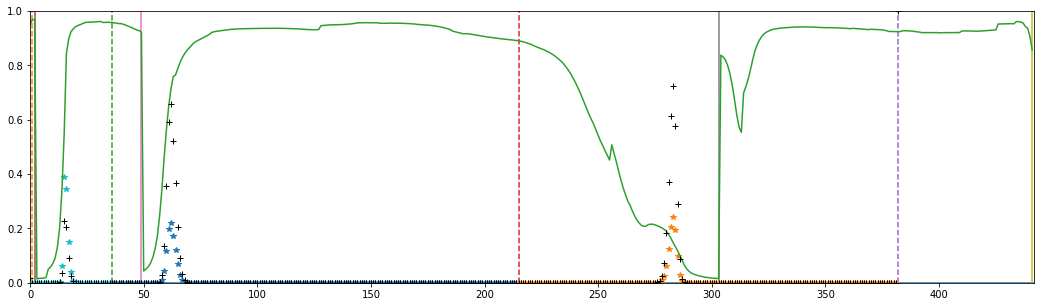

In [78]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in loaded_vidid_selected_frames[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
    segment = segment.cpu().numpy()
    print(f"Min prob {i} = {np.min(segment).item()}")
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid + ".txt"][i], 
                   loaded_vidid_selected_frames[cur_vidid + ".txt"][i+1])
    plt.plot(xs, segment, '*')

    
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 
plt.plot(np.arange(item[1][idx].item()), plt_arr)


loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))
loss_arr = -loss_arr[0].detach().cpu().numpy()
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr/np.max(loss_arr), 'k+')

plt.ylim([0, ymax])
plt.xlim([0, item[1][idx].item()])

In [40]:
loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
print(loss_prob.shape)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))

torch.Size([1, 1895, 48])


In [43]:
loss_arr[0].shape

torch.Size([1387])

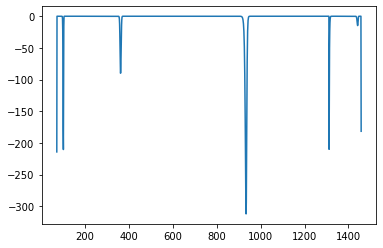

In [45]:
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr[0].detach().cpu().numpy())

In [44]:
es_loss

tensor(3.3987, device='cuda:0', dtype=torch.float64)

In [35]:
video_id_boundary_frames[cur_vidid], loaded_vidid_selected_frames[cur_vidid + ".txt"], item_1[idx]

([75, 345, 1305, 1415, 1440, 1519],
 [73, 282, 455, 1312, 1434, 1458],
 tensor(1520, device='cuda:0', dtype=torch.int32))

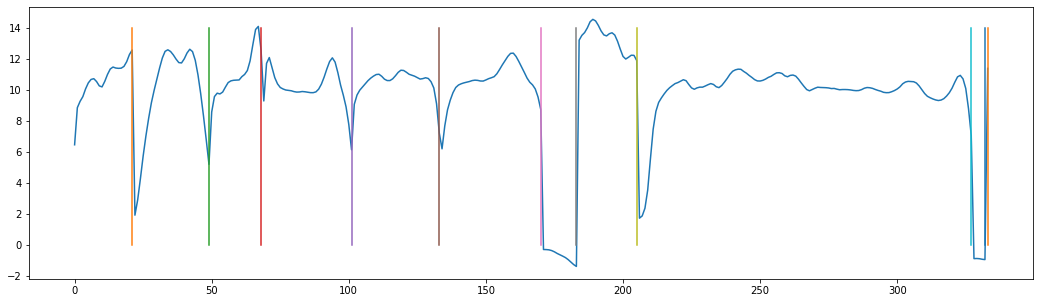

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss